# Multivariate analyses for untargeted metabolomics data

By M Ernst [add your names here]

In this notebook we will perform a Principal Coordinate Analysis (PCoA), also known as metric or classical Multidimensional Scaling (metric MDS) to explore and visualize patterns in an untargeted mass spectromtery-based metabolomics dataset. We will then assess statistical significance of the patterns and dispersion of different sample types using permutational multivariate analysis of variance (PERMANOVA).

#### Data

The files used in this tutorial are a subset of an untargeted [LC-MS/MS metabolomics dataset](https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?accession=MSV000089534) of bacterial cultures to which pooled antibiotics were added (sulfomethoxazole, sulfadimethoxine, cyproconazole and asulam) to investigate potential biotransformations. [needs to be replaced] Data were acquired on a Dionex UltiMate 3000 Thermo Fisher Scientific HPLC system coupled to a Bruker Impact HD quadrupole time of flight (qTOF) mass spectrometer. MS/MS data were acquired in data dependent acquisition (DDA) with fragmentation of the seven most abundant ions in the spectrum [needs to be replaced]. Data files were subsequently preprocessed using [MZmine2](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-11-395) and the [feature-based molecular networking workflow in GNPS](https://www.nature.com/articles/s41592-020-0933-6).

#### Questions

- Is there a difference in the metabolomic profiles of different bacterial species?
- Is there a difference in the metabolomic profiles of different sample types?
- Is there a difference in the bacterial metabolomic profiles across different timepoints?

Install and load libraries

In [1]:
#install.packages('vegan')
#install.packages('ggplot2')
library(vegan)
library(ggplot2)

Warning message:
“package ‘vegan’ was built under R version 4.1.2”
Loading required package: permute

Loading required package: lattice

This is vegan 2.6-2

Warning message:
“package ‘ggplot2’ was built under R version 4.1.2”


Specify where the data can be found by providing urls for the featuretable and metadata

In [2]:
## Non-gap filled
# ft_url <- 'https://raw.githubusercontent.com/madeleineernst/Metabolomics_SummerSchool_2022/main/data/MZmine/Xenobiotic_Metabolism_ChemProp2_NonGapFilled_QuantTable.csv'
## Gap filled
ft_url <- 'https://raw.githubusercontent.com/madeleineernst/Metabolomics_SummerSchool_2022/main/data/MZmine/Xenobiotic_Metabolism_ChemProp2_GapFilled_QuantTable.csv'
md_url <- 'https://raw.githubusercontent.com/madeleineernst/Metabolomics_SummerSchool_2022/main/data/Xenobiotic_Metabolism_metadata.txt'

Load featuretable and metadata

In [3]:
ft <- read.csv(ft_url, header = T, check.names = F)
md <- read.csv(md_url, header = T, check.names = F, sep = '\t')

In [4]:
head(ft)

,row ID,row m/z,row retention time,row ion mobility,row ion mobility unit,row CCS,correlation group ID,annotation network number,best ion,auto MS2 verify,⋯,t8_Ec_3.mzML Peak area,t8_Ec_C.mzML Peak area,t9_BS_1.mzML Peak area,t9_BS_2.mzML Peak area,t9_BS_3.mzML Peak area,t9_BS_C.mzML Peak area,t9_Ec_1.mzML Peak area,t9_Ec_2.mzML Peak area,t9_Ec_3.mzML Peak area,t9_Ec_C.mzML Peak area
,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,284.0490,0.07352047,NA,NA,NA,NA,NA,NA,NA,⋯,29405.38,23104.44,25643.28,24276.26,27789.33,7223.985,25101.52,28556.88,28486.47,27427.04
2,6,267.0352,0.11644413,NA,NA,NA,NA,NA,NA,NA,⋯,153205.45,59329.62,152010.89,141858.53,144812.08,71790.380,149117.70,160368.38,157908.19,155249.89
3,8,281.0509,0.11666454,NA,NA,NA,NA,NA,NA,NA,⋯,318348.78,2230275.20,2232071.80,2149341.50,2186300.80,1151338.000,2165031.50,2294908.20,2246502.20,2231282.20
4,11,227.0220,0.02547601,NA,NA,NA,NA,NA,NA,NA,⋯,77031.52,29224.25,77089.79,44565.51,75053.59,22575.890,38971.95,68738.09,63997.76,74839.20
5,13,239.0947,0.02616518,NA,NA,NA,NA,NA,NA,NA,⋯,26745.67,98362.26,12844.57,99819.69,58561.92,53665.600,37889.34,100194.13,84681.64,55763.07
6,15,284.0490,0.15191087,NA,NA,NA,NA,NA,NA,NA,⋯,59815.75,144806.06,65065.07,18545.58,23812.42,19355.408,62776.63,25392.14,173070.67,50639.06


In [5]:
head(md)

,filename,ATTRIBUTE_species,ATTRIBUTE_sample,ATTRIBUTE_timepoint,ATTRIBUTE_hours,ATTRIBUTE_mins,ATTRIBUTE_replicates,,,,,,
,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,t0_BS_1.mzML Peak area,B.subtilis,sample,0,-0.1666667,-10,1,NA,NA,NA,NA,NA,NA
2,t0_BS_2.mzML Peak area,B.subtilis,sample,0,-0.1666667,-10,2,NA,NA,NA,NA,NA,NA
3,t0_BS_3.mzML Peak area,B.subtilis,sample,0,-0.1666667,-10,3,NA,NA,NA,NA,NA,NA
4,t0_BS_C.mzML Peak area,B.subtilis,Control,0,-0.1666667,-10,0,NA,NA,NA,NA,NA,NA
5,t0_Ec_1.mzML Peak area,E.coli,sample,0,-0.1666667,-10,1,NA,NA,NA,NA,NA,NA
6,t0_Ec_2.mzML Peak area,E.coli,sample,0,-0.1666667,-10,2,NA,NA,NA,NA,NA,NA


Bring featuretable and metadata in the correct format:

- Get rid of 'Peak area' extension in filenames to match with metadata and transform metadata rownames to filenames, transform featuretable rownames to feature IDs, m/z and RT
- Remove NA columns from metadata

In [6]:
colnames(ft) <- gsub(' Peak area','',colnames(ft))
md$filename <- gsub(' Peak area','',md$filename)
md <- md[,colSums(is.na(md))<nrow(md)]
rownames(md) <- md$filename
rownames(ft) <- paste(ft$'row ID',round(ft$'row m/z',digits = 3),round(ft$'row retention time',digits = 3), sep = '_')
ft <- ft[,grep('mzML',colnames(ft))]
md$ATTRIBUTE_replicates <- as.factor(md$ATTRIBUTE_replicates)

Show featuretable and metadata headers and table dimensions

In [7]:
head(ft)
dim(ft)

,t0_BS_1.mzML,t0_BS_2.mzML,t0_BS_3.mzML,t0_BS_C.mzML,t0_Ec_1.mzML,t0_Ec_2.mzML,t0_Ec_3.mzML,t0_Ec_C.mzML,t1_BS_1.mzML,t1_BS_2.mzML,⋯,t8_Ec_3.mzML,t8_Ec_C.mzML,t9_BS_1.mzML,t9_BS_2.mzML,t9_BS_3.mzML,t9_BS_C.mzML,t9_Ec_1.mzML,t9_Ec_2.mzML,t9_Ec_3.mzML,t9_Ec_C.mzML
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2_284.049_0.074,17433.18,4355.322,10024.89,20755.18,22109.19,4875.964,22036.09,1897.219,20930.33,5378.233,⋯,29405.38,23104.44,25643.28,24276.26,27789.33,7223.985,25101.52,28556.88,28486.47,27427.04
6_267.035_0.116,75040.11,78208.430,78494.91,76631.37,82040.83,10763.729,83026.68,80481.480,78644.99,68145.160,⋯,153205.45,59329.62,152010.89,141858.53,144812.08,71790.380,149117.70,160368.38,157908.19,155249.89
8_281.051_0.117,1697266.20,1631237.000,1627597.10,228957.92,242289.98,1642048.900,1705003.10,1626212.600,1610743.20,1617801.000,⋯,318348.78,2230275.20,2232071.80,2149341.50,2186300.80,1151338.000,2165031.50,2294908.20,2246502.20,2231282.20
11_227.022_0.025,25428.31,3144.417,28229.96,32815.08,46982.75,31859.559,53433.33,53151.668,21978.04,33175.940,⋯,77031.52,29224.25,77089.79,44565.51,75053.59,22575.890,38971.95,68738.09,63997.76,74839.20
13_239.095_0.026,95145.99,46588.438,100999.84,101895.63,41008.70,100406.810,34433.39,98985.750,47213.04,52947.160,⋯,26745.67,98362.26,12844.57,99819.69,58561.92,53665.600,37889.34,100194.13,84681.64,55763.07
15_284.049_0.152,88282.33,36163.434,38635.61,121834.44,39719.41,89345.800,48019.90,40891.207,44813.21,44965.720,⋯,59815.75,144806.06,65065.07,18545.58,23812.42,19355.408,62776.63,25392.14,173070.67,50639.06


[1] 6899   80

In [8]:
head(md)
dim(md)

,filename,ATTRIBUTE_species,ATTRIBUTE_sample,ATTRIBUTE_timepoint,ATTRIBUTE_hours,ATTRIBUTE_mins,ATTRIBUTE_replicates
,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<fct>
t0_BS_1.mzML,t0_BS_1.mzML,B.subtilis,sample,0,-0.1666667,-10,1
t0_BS_2.mzML,t0_BS_2.mzML,B.subtilis,sample,0,-0.1666667,-10,2
t0_BS_3.mzML,t0_BS_3.mzML,B.subtilis,sample,0,-0.1666667,-10,3
t0_BS_C.mzML,t0_BS_C.mzML,B.subtilis,Control,0,-0.1666667,-10,0
t0_Ec_1.mzML,t0_Ec_1.mzML,E.coli,sample,0,-0.1666667,-10,1
t0_Ec_2.mzML,t0_Ec_2.mzML,E.coli,sample,0,-0.1666667,-10,2


[1] 80  7

In [9]:
length(which(rownames(md) %in% colnames(ft)))

[1] 80

The data table headers and dimensions tell us that our dataset consists of 80 samples with measured relative abundance of 6899 mass spectral features. From the metadata table we can furthermore see that each of the 80 samples is associated with 6 metadata descriptors, specifying sample type, bacterial species, timepoint, hours, minutes and replicate ID.

## Principal coordinates analysis (PCoA) 

Principal coordinates analysis (PCoA) is a metric multidimensional scaling (MDS) method that attempts to represent sample dissimilarities in a low-dimensional space. It converts a distance matrix consisting of pair-wise distances (dissimilarities) across samples into a 2- or 3-D graph ([Gower, 2005](https://doi.org/10.1002/0470011815.b2a13070)). Different distance metrics can be used to calculate dissimilarities among samples (e.g. Euclidean, Canberra, Minkowski). Performing a principal coordinates analysis using the Euclidean distance metric is the same as performing a principal components analysis (PCA). Selecting the best distance metric for a given dataset is part of the 'art' of data science.

Within the metabolomics field the Euclidean, Bray-Curtis, Jaccard or Canberra distances are most commonly used. The Jaccard distance is an unweighted metric (presence/absence) whereas Euclidean, Bray-Curtis and Canberra distances take into account relative abundances (weighted). 


This video tutorial by StatQuest summarizes nicely the basic principles of PCoA: https://www.youtube.com/watch?v=GEn-_dAyYME

In order to perform a PCoA as described below, it is important that the filenames in our metadata are identical as well as in the same order as the filenames in our featuretable. Let's make sure this is true, using the below code (this should return TRUE).

In [10]:
md <- md[which(md$filename%in%colnames(ft)),]
md <- md[match(colnames(ft),md$filename),]
identical(colnames(ft),md$filename)

[1] TRUE

Then, we will assess the sparsity of our data matrix (how many zeroes does our data matrix contain)

In [11]:
sum(ft == 0)/(dim(ft)[1]*dim(ft)[2])

[1] 0.391901

This tells us that around 39% of our featuretable consists of 0s, which is quite high, but very common within the metabolomics field.

Next, we will calculate pairwise distances across all samples using the Canberra distance metric

In [12]:
distm <- dist(t(ft), method = 'canberra')

All pairwise Canberra distances are now stored within our distance (dissimilarity) matrix (distm)

In [13]:
distm

             t0_BS_1.mzML t0_BS_2.mzML t0_BS_3.mzML t0_BS_C.mzML t0_Ec_1.mzML
t0_BS_2.mzML     1632.477                                                    
t0_BS_3.mzML     1621.399     1596.693                                       
t0_BS_C.mzML     5306.636     5096.888     5096.196                          
t0_Ec_1.mzML     4079.804     3999.048     3830.638     4633.275             
t0_Ec_2.mzML     4142.282     4034.572     3934.385     4623.517     1571.942
t0_Ec_3.mzML     4169.563     4080.604     3975.652     4795.351     1614.721
t0_Ec_C.mzML     5474.842     5392.777     5297.058     2733.145     4696.118
t1_BS_1.mzML     3871.141     3818.904     3686.387     5015.485     2853.254
t1_BS_2.mzML     3922.584     3877.332     3742.161     5103.799     2881.281
t1_BS_3.mzML     3998.859     3871.147     3813.231     5070.277     2982.935
t1_BS_C.mzML     5589.156     5533.348     5431.682     3124.678     4949.941
t1_Ec_1.mzML     4435.881     4371.228     4297.587     5112.096

And the distance matrix is then used as input for the PCoA. At first, we here color samples according to the bacterial species (ATTRIBUTE_species within our metadata)

In [14]:
PcoA <- cmdscale(distm, k =2)
PcoA <- as.data.frame(PcoA)
PcoA$Group <- md[,colnames(md) == "ATTRIBUTE_species"][match(rownames(PcoA),rownames(md))]
names(PcoA)[1:2] <- c('PC1', 'PC2')

Using the [ggplot2](https://cran.r-project.org/web/packages/ggplot2/index.html) library, we can plot our PCoA

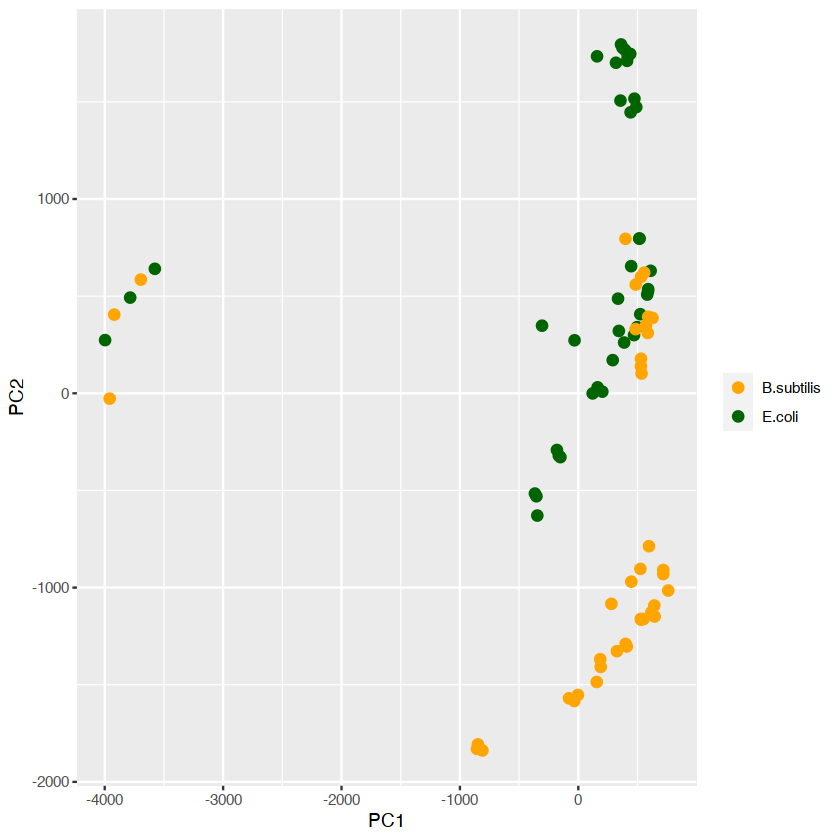

In [15]:
ggplot(PcoA, aes(x = PC1, y = PC2, colour = Group, label = row.names(PcoA))) + geom_point(size=2.5) +
            scale_colour_manual(values = c('orange','darkgreen','red','pink','brown','blue','skyblue3','green','grey','black')) +
            theme(legend.title=element_blank()) 

It looks like there is a strong separation between samples of E.coli and B. subtilis. But is the separation significant? Let's perform a permutational multivariate analysis of variance (PERMANOVA) to find out!

## Permutational multivariate analysis of variance (PERMANOVA)

Permutational multivariate analysis of variance (PERMANOVA) is a non-parametric method for multivariate analysis of variance, where P-values are obtained using permutations. The metric was originally developed within the field of ecology ([Anderson, 2008](https://onlinelibrary.wiley.com/doi/10.1111/j.1442-9993.2001.01070.pp.x)) but is today widely used in other fields, including the microbiome and metabolomics field. PERMANOVA is used to compare groups of samples and tests whether the centroid and/or the spread of the samples is different between the groups. 

The adonis2() function in the [vegan package](https://cran.r-project.org/web/packages/vegan/index.html) can be used to perform a PERMANOVA. The input is any dissimilarity matrix and the test-statistic retrieved is a multivariate analogue to Fisher's F-ratio as well as an R<sup>2</sup> value (Adonis R<sup>2</sup>).

In [16]:
adonres <- adonis2(distm ~ md[,colnames(md) == 'ATTRIBUTE_species'])

In [17]:
adonres

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"md[, colnames(md) == ""ATTRIBUTE_species""]",1,66908377,0.1401149,12.70979,0.001
Residual,78,410616720,0.8598851,NA,NA
Total,79,477525098,1.0000000,NA,NA


The PERMANOVA test result tells us that there is a significant difference in the metabolomic profiles of E.coli and B.subtilis (PERMANOVA, P < 0.05, Adonis R<sup>2</sup> = 0.1401) and that app. 14% of the variation in our data can be explained by bacterial species.

## Perform PCoA and assess separation using PERMANOVA

To speed up the analysis and so we don't have to explore all metadata categories one by one, we can define a function, which will perform a principal coordinates analysis (PCoA) using a distance metric of choice, calculate a PERMANOVA and plot results in a 2-D graph:

In [18]:
plotPCoA <- function(ft, md, distmetric = c("euclidean", "maximum", "manhattan", "canberra", "binary", 
                                                  "minkowski"), collow = "#810f7c", colhigh ="#f7fcb9", 
                      catper = "plate", catcols = "plate", mdtype = 'categorical', 
                      cols = c('grey','black','orange','pink','darkgreen','darkred','brown','blue','skyblue3','green'),
                      title = 'Principal coordinates plot'){
    
    catper <<- catper
    distm <- dist(t(ft), method = distmetric)
    d <- as.matrix(distm)

    if (length(which(is.na(md[,colnames(md) == catper]))) !=0){
          red <- as.dist(as.matrix(distm)[-which(is.na(md[,colnames(md) == catper])),-which(is.na(md[,colnames(md) == catper]))])
          adonres <- adonis2(red ~ na.omit(md[,colnames(md) == catper]))
          Rsq <- adonres$R2[1]
          pval <- adonres$'Pr(>F)'[1]
        } else {
          adonres <- adonis2(distm ~ md[,colnames(md) == catper])
          Rsq <- adonres$R2[1]
          pval <- adonres$'Pr(>F)'[1]
        }

    PcoA <- cmdscale(distm, k =2)
    PcoA <- as.data.frame(PcoA)
    PcoA$Group <- md[,colnames(md) == catcols][match(rownames(PcoA),rownames(md))]
    names(PcoA)[1:2] <- c('PC1', 'PC2')
    
    # plot
    cbPalette <- cols

    if (mdtype == 'continuous'){
          Tr_PcoA <- ggplot(PcoA, aes(x = PC1, y = PC2, colour = Group, label = row.names(PcoA))) + geom_point(size=2.5) +
            scale_colour_gradient(low = collow, high = colhigh,space = "Lab", na.value = "grey50", guide = "colourbar",aesthetics = "colour")+
            theme(legend.title=element_blank()) +
            ggtitle(paste(title,paste0("(p=",round(pval,4),","),paste0("adonis-R2=",round(Rsq,4),")"),sep=" "))

        } else {

          Tr_PcoA <- ggplot(PcoA, aes(x = PC1, y = PC2, colour = Group, label = row.names(PcoA))) + geom_point(size=2.5) +
            scale_colour_manual(values = cbPalette) +
            theme(legend.title=element_blank()) +
            ggtitle(paste(title,paste0("(p=",round(pval,4),","),paste0("adonis-R2=",round(Rsq,4),")"),sep=" "))
        }
    
    print(Tr_PcoA)
}

By defining different parameters within the plotPCoA function:

- <b>distmetric</b>: A distance metric of your choice, including "euclidean", "maximum", "manhattan", "canberra", "binary" or "minkowski".
- <b>catper</b>: How should the samples be grouped for PERMANOVA, this can be any column name of your metadata.
- <b>catcols</b>: According to what groups should the samples be colored on the PCoA, this can be any column name of your metadata.
- <b>mdtype</b>: Either 'categorical' or 'continuous', this value defines whether a continuous or categorical color scale should be used for the PCoA.
- <b>cols</b>: Colors used for plotting the groups in the PCoA. The length of this object should be equal to the number of groups plotted.
- <b>title</b>: Any title of your choice you want to give the plot.


you can now quickly explore different research questions such as:

- Is there a difference in the metabolomic data of different bacterial species? How much of the variation in our data can be explained by the bacterial species?

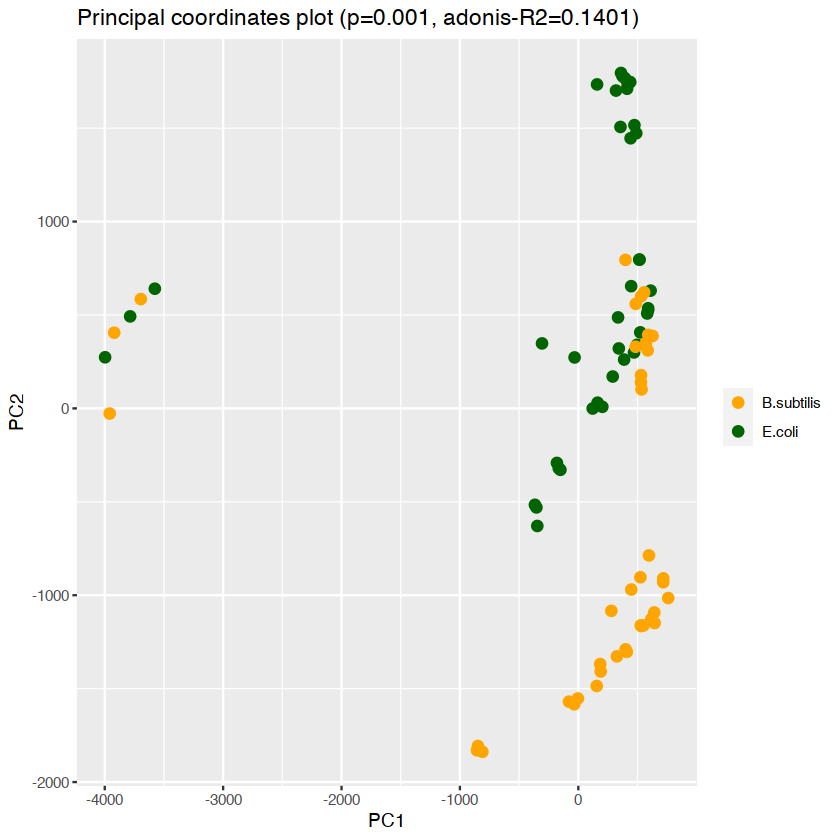

In [19]:
plotPCoA(ft, md, distmetric = "canberra", catper = "ATTRIBUTE_species", catcols = "ATTRIBUTE_species", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','pink','brown','blue','skyblue3','green','grey','black'),
                      title = 'Principal coordinates plot')

There is a significant difference in the metabolomic profiles of E.coli and B.subtilis (PERMANOVA, P < 0.05, Adonis R<sup>2</sup> = 0.1401). 14% of the variation in our data can be explained by bacterial species.

- Is there a significant difference between samples and controls? How much of the variation in our data can be explained by sample type?

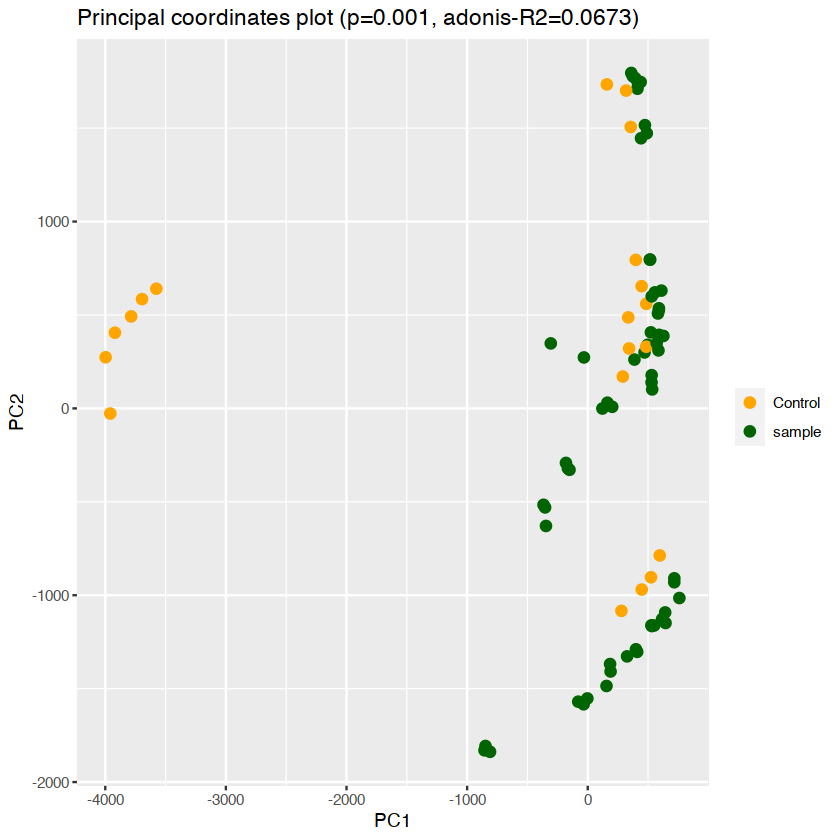

In [20]:
plotPCoA(ft, md, distmetric = "canberra", catper = "ATTRIBUTE_sample", catcols = "ATTRIBUTE_sample", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','pink','brown','blue','skyblue3','green','grey','black'),
                      title = 'Principal coordinates plot')

There is a significant difference in the metabolomic profiles of samples and controls (PERMANOVA, P < 0.05, Adonis R<sup>2</sup> = 0.0673). 6.7% of the variation in our data can be explained by sample type.

- Is there a significant difference between different timepoints? How much of the variation in our data can be explained by the timepoint the sample was collected?

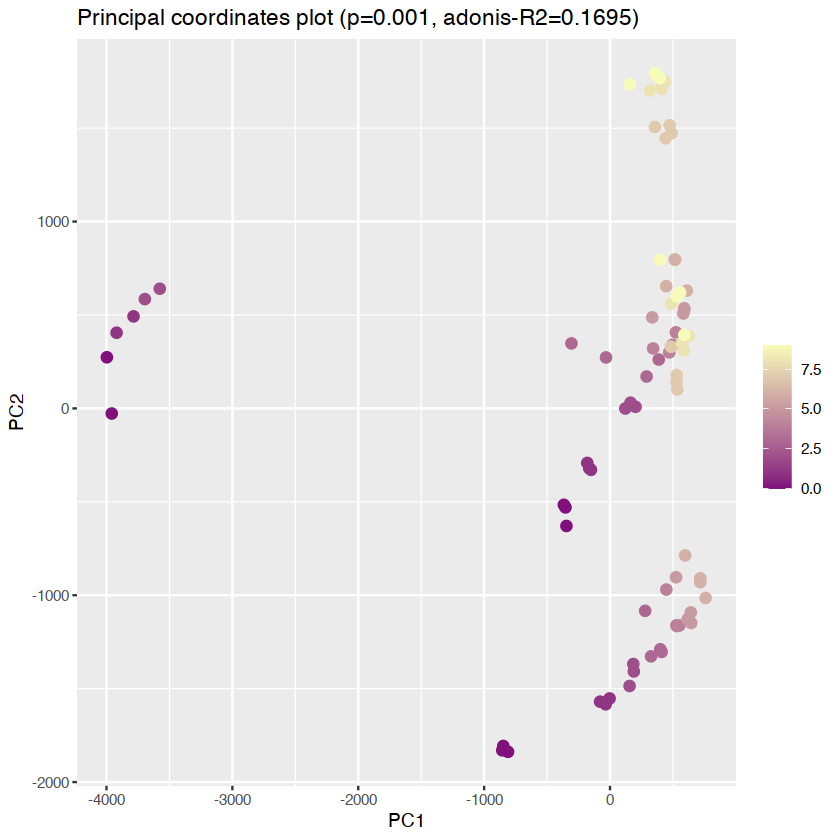

In [21]:
plotPCoA(ft, md, distmetric = "canberra", catper = "ATTRIBUTE_timepoint", catcols = "ATTRIBUTE_timepoint", mdtype = 'continuous', 
                      cols = c('orange','darkgreen','red','pink','brown','blue','skyblue3','green','grey','black'),
                      title = 'Principal coordinates plot')

- Is there a significant difference between different timepoints (in hours)? How much of the variation in our data can be explained by the timepoint the sample was collected?

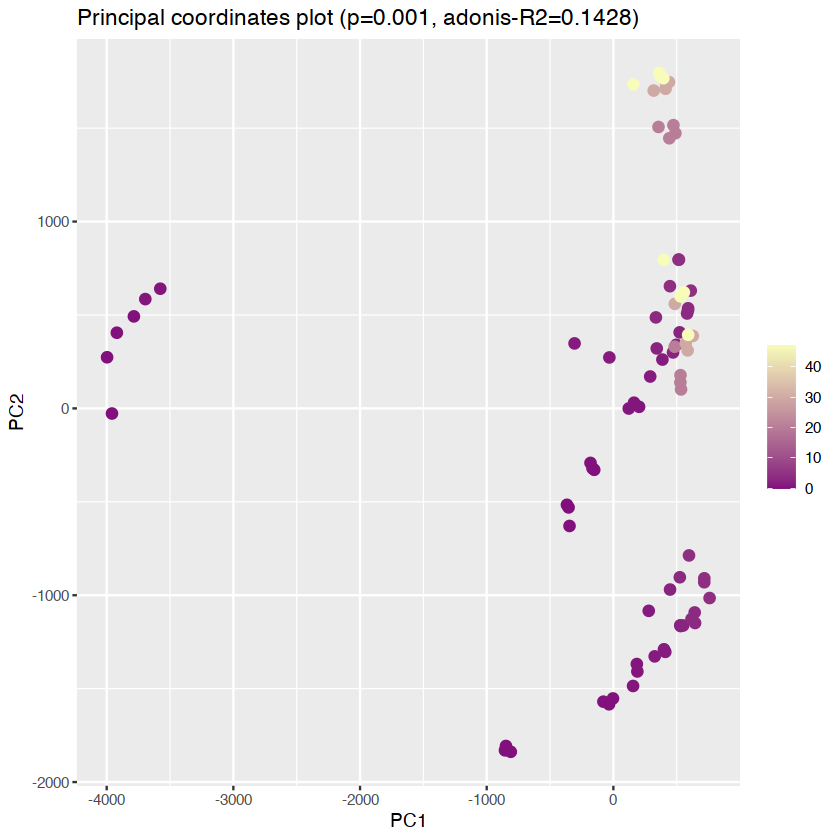

In [22]:
plotPCoA(ft, md, distmetric = "canberra", catper = "ATTRIBUTE_hours", catcols = "ATTRIBUTE_hours", mdtype = 'continuous', 
                      cols = c('orange','darkgreen','red','pink','brown','blue','skyblue3','green','grey','black'),
                      title = 'Principal coordinates plot')

- Is there a significant difference between different timepoints (in minutes)? How much of the variation in our data can be explained by the timepoint the sample was collected?

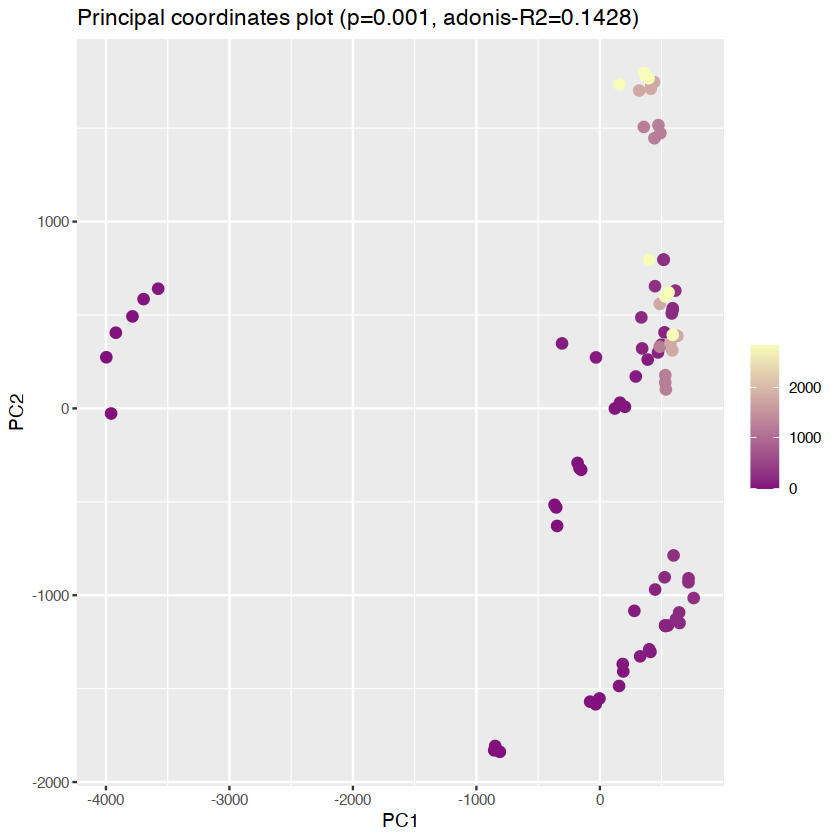

In [23]:
plotPCoA(ft, md, distmetric = "canberra", catper = "ATTRIBUTE_mins", catcols = "ATTRIBUTE_mins", mdtype = 'continuous', 
                      cols = c('orange','darkgreen','red','pink','brown','blue','skyblue3','green','grey','black'),
                      title = 'Principal coordinates plot')

There is a significant difference in the metabolomic profiles of samples collected at different timepoints (PERMANOVA, P < 0.05, Adonis R<sup>2</sup> ≈ 0.15). ≈ 15% of the variation in our data can be explained by timepoint.

- Is there a significant difference between replicates? How much of the variation in our data can be explained by different replicates?

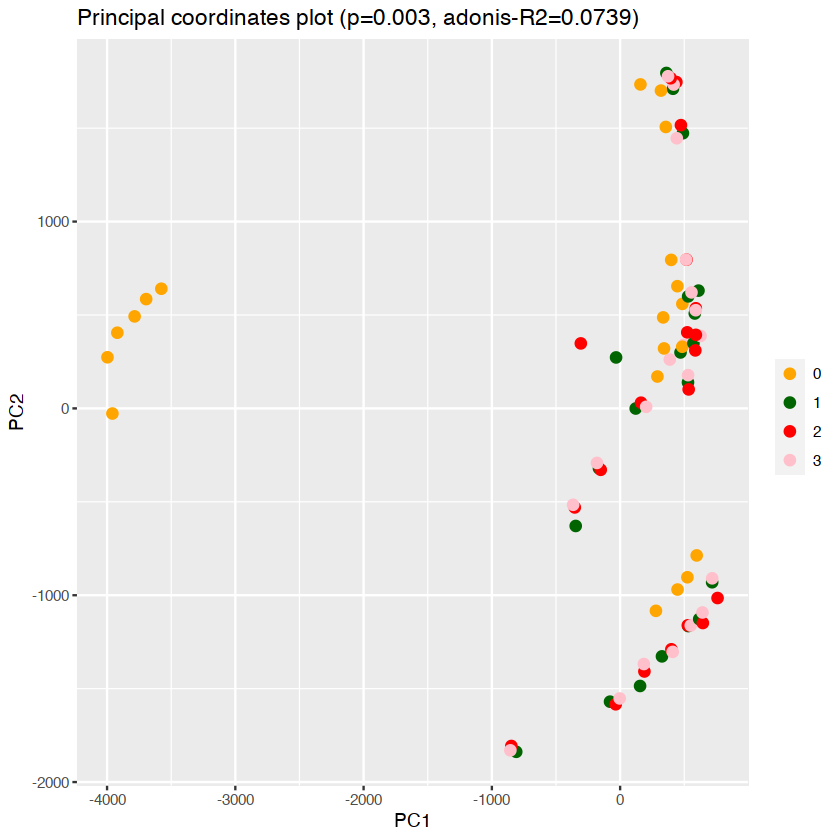

In [24]:
plotPCoA(ft, md, distmetric = "canberra", catper = "ATTRIBUTE_replicates", catcols = "ATTRIBUTE_replicates", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','pink','brown','blue','skyblue3','green','grey','black'),
                      title = 'Principal coordinates plot')

There is a significant difference in the metabolomic profiles of different replicate samples (PERMANOVA, P < 0.05, Adonis R<sup>2</sup> = 0.0739). 7.4% of the variation in our data can be explained by replicate type.